

# Chapter 13 最小二乗データのフィッティング

## 13.1 最小二乗データフィッティング

### 直線のフィッティング

時系列データへ直線をフィッティングすると，トレンドの直線を推定することができる．本書の図13.3では石油消費量の時系列データへ適用する．図13.1にもその結果を示す．

In [2]:
using Plots

In [3]:
# 石油消費量（1000バレル/日単位）
consumption = petroleum_consumption_data();
n = length(consumption);
A = [ ones(n) 1:n ];
x = A \ consumption;

scatter(1980:2013, consumption, legend=false)
plot!(1980:2013, A*x)

UndefVarError: UndefVarError: petroleum_consumption_data not defined

![図13.1](fig13-1.pdf)

図13.1 1980年から2013年までの世界の石油の年間消費量（丸点）と最小二乗法でフィッティングした直線（データは`www.eia.gov`より）


### トレンドと季節変動成分tの推定

次の例では，時系列データのトレンドだけでなく，周期的な成分も推定する．本書では，2000年から2014年までの15年間に，アメリカ国内で車両が移動した距離（マイル）の月毎の時系列データを扱う．以下のJuliaコードは，本書の図13.5を作成する．まず関数`vehicle_miles_data`でデータを読み込み，15年間の毎月のデータで$15 \times 12$行列`vmt`を作成する．

In [7]:
using VMLS

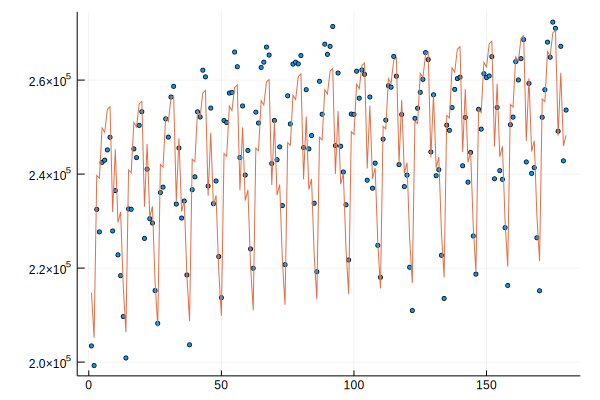

In [8]:
vmt = vehicle_miles_data(); # 15x12行列
m = 15 * 12;
A = [ 0:(m-1) vcat([eye(12) for i=1:15]...) ];
b = reshape(vmt', m, 1);
x = A \ b;

scatter(1:m, b, markersize = 2, legend =false);
plot!(1:m, A*x)

![図13.2](fig13-2.pdf)

図13.2 2000年1月から2014年12月までの，アメリカ国内で車両が移動した距離の月毎の時系列データ（点）と，線形トレンドと12ヶ月周期の季節変動成分を最小二乗法でフィッティングした結果（実線）．



この例では，行列$A$のサイズは$m \times n$で，$m = 15\cdot 12 = 180$, $n=13$である．第1列の要素は$0, 1, 2, \ldots, 179$である．残りの列は，サイズ$12 \times 12$の単位行列を縦方向に15個スタックしたものである．Juliaの式`vcat([eye(12) for i=1:15]...)`は，15個の単位行列の配列を作成し，縦方向にスタックする．このコードでプロットしたものが図13.2である．




### 多項式のフィッティング

本書＊＊ページの多項式フィッティング問題と図13.6の結果を取り上げる．まず100点からなる訓練集合を生成し，それをプロットする（図13.3）．

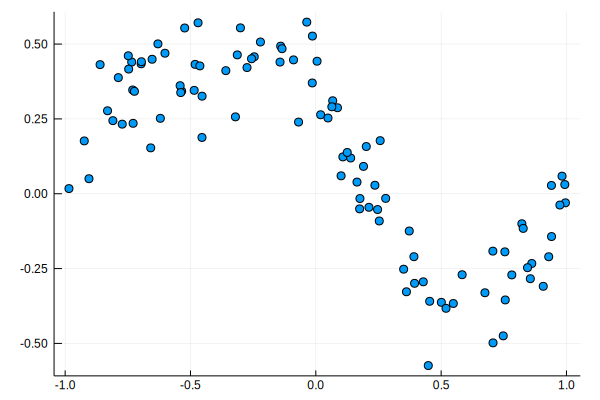

In [9]:
# 区間[-1, 1]から訓練集合を生成
m = 100;
t = -1 .+ 2*rand(m,1);
y = t.^3 - t + 0.4 ./ (1 .+ 25*t.^2) + 0.10*randn(m,1);

scatter(t, y, legend=false)

次に最小二乗法で多項式係数を推定する関数を定義する．この関数を，2次，6次，10次，15次の多項式で訓練集合に適用する．


In [10]:
polyfit(t, y, p) = vandermonde(t, p) \ y

polyfit (generic function with 1 method)

In [13]:
theta2 = polyfit(t, y, 3);
theta6 = polyfit(t, y, 7);
theta10 = polyfit(t, y, 11);
theta15 = polyfit(t, y, 16);

最後に，4つの多項式をプロットする．これを簡単に行うために，与えられたベクトル`x`のすべての点で多項式を評価する関数を定義しておく．プロットを図13.4に示す．

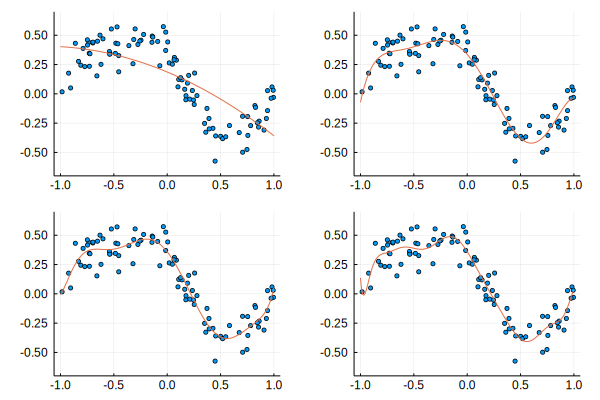

In [14]:
polyeval(theta, x) = vandermonde(x, length(theta)) * theta;
t_plot = linspace(-1, 1, 1000);

p = plot(layout=4, legend=false, ylim=(-0.7, 0.7))
scatter!(t, y, subplot=1, markersize = 2)
plot!(t_plot, polyeval(theta2,t_plot), subplot=1)
scatter!(t, y, subplot=2, markersize = 2)
plot!(t_plot, polyeval(theta6,t_plot), subplot=2)
scatter!(t, y, subplot=3,markersize = 2)
plot!(t_plot, polyeval(theta10,t_plot), subplot=3)
scatter!(t, y, subplot=4, markersize = 2)
plot!(t_plot, polyeval(theta15,t_plot), subplot=4)


![図13.3](fig13-3.pdf)

図13.3 多項式フィッティングの例で使用する訓練集合

![図13.4](fig13-4.pdf)

図13.4 2次，6次，10次，15次の多項式を100点に最小二乗法でフィッティングした結果



### 区分線形当てはめ

以下のコードは100点に対して区分線形関数を最小二乗法で当てはめる．その結果は図13.5であり，本書の図13.8と似たような結果である．

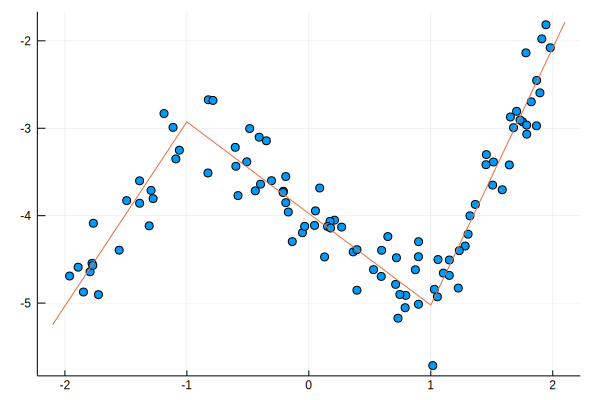

In [15]:
# ランダムなデータを生成
m = 100;
x = -2 .+ 4*rand(m,1);
y = 1 .+ 2*(x.-1) - 3*max.(x.+1,0) + 4*max.(x.-1,0) + 0.3*randn(m,1);
# 最小二乗当てはめ
theta = [ ones(m)  x   max.(x.+1,0)  max.(x.-1,0) ] \ y;
# 結果をプロット
t = [-2.1, -1, 1, 2.1];
yhat = theta[1] .+ theta[2]*t + theta[3]*max.(t.+1,0) + theta[4]*max.(t.-1,0);
scatter(x, y, legend=false)
plot!(t, yhat)

![図13.5](fig13-5.pdf)

図13.5 100点への区分線形関数のフィッテイング



### 家の売却価格の回帰

サクラメントの774件分の家の売却価格のデータを使って，面積とベッドルーム数から売却価格を予測する単純な回帰モデルを計算しよう．

In [16]:
D = house_sales_data();  # 3次元ベクトル：面積，ベッドルーム数，価格
area = D["area"];
beds = D["beds"];
price = D["price"];
m = length(price);
A = [ ones(m) area beds ];

In [17]:
x = A \ price

3-element Array{Float64,1}:
  54.40167360394445
 148.7250726002902 
 -18.85335787777865

In [18]:
rms_error = rms(price - A*x)

74.84571649590146

In [19]:
std_prices = stdev(price)

112.78216159756509

### 時系列の自己回帰モデル

以下のJuliaコードは，本書＊＊＊ページの温度の時系列に自己回帰モデルをフィッティングする．図13.6は，最初の5日間のこのモデルの予測と実際のデータの比較である．


In [20]:
# 温度tの時系列の読み込み
t = temperature_data();
N = length(t)

744

In [21]:
stdev(t) # 標準偏差

3.05055928562933

In [22]:
# zhat_{t+1} = z_t という単純な予測のRMS誤差
rms(t[2:end] - t[1:end-1])

1.1602431638206119

In [23]:
# zhat_{t+1} = z_{t-23} という単純な予測のRMS誤差
rms(t[25:end] - t[1:end-24])

1.7338941400468744

In [24]:
# 8次ARモデルの最小二乗当てはめ
M = 8
y = t[M+1:end];
A = hcat( [ t[i:i+N-M-1] for i = M:-1:1]...);
theta = A \ y;
ypred = A * theta;

In [25]:
# RMS error of LS AR fit
rms(ypred - y)

1.0129632612687507

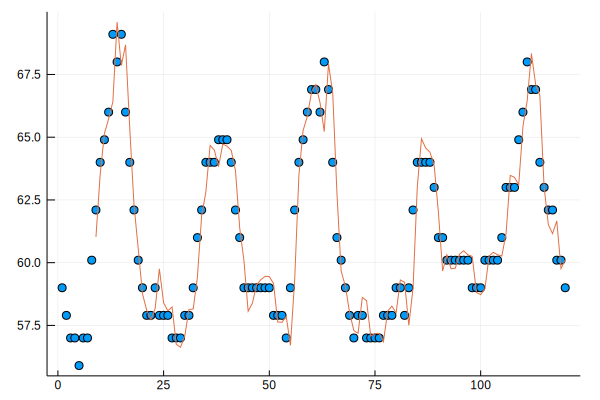

In [26]:
# 最初の5日間をプロット
using Plots
Nplot = 24*5
scatter(1:Nplot, t[1:Nplot], legend =false)
plot!(M+1:Nplot, ypred[1:Nplot-M])

![図13.6](fig13-6.pdf)

図13.6 2016年5月1日午前12:53から2016年5月5日午後11:53までのロサンゼルス国際空港の1時間毎の気温（点）と自己回帰モデル（係数8個）の予測結果（実線）



## 13.2 検証

### 多項式近似

＊＊＊ページの多項式フィッティングの例に戻る．＊＊＊ページのコードと同様に，ベクトル`t` と`y`を訓練集合とする[^ty]．さらに，この訓練集合を生成したものと同じコードで，100点からなるテスト集合を生成する．多項式フィッティングの次数を$0 ,\ldots, 20$とし（つまり$p=1,\ldots,21$個の係数を持つ），訓練集合とテスト集合のRMS誤差を計算する．図13.7はその結果であり，これは本書の図13.11と同様のものである．

[^ty] （訳注）ランダムにデータを生成するので，場合によっては次数が20付近で非常に誤差が大きくなることもある．

In [28]:
using LinearAlgebra

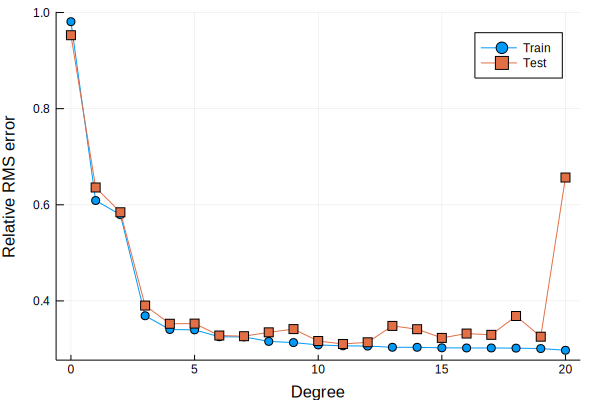

In [29]:
# 訓練集合を生成
m = 100;
t = -1 .+ 2*rand(m,1);
y = t.^3 - t + 0.4 ./ (1 .+ 25*t.^2) + 0.10*randn(m,1);
# テスト集合を生成
m = 100;
t_test = -1 .+ 2*rand(m,1);
y_test = t_test.^3 - t_test + 0.4 ./ (1 .+ 25*t_test.^2) + 0.10*randn(m,1);
error_train = zeros(21);
error_test = zeros(21);
for p = 1:21
   A = vandermonde(t,p)
   theta = A \ y
   error_train[p] = norm(A*theta - y) / norm(y)
   error_test[p] = norm( vandermonde(t_test, p) * theta - y_test) / norm(y_test);
end

plot(0:20, error_train, label = "Train", marker = :circle)
plot!(0:20, error_test, label = "Test", marker = :square)
plot!(xlabel="Degree", ylabel = "Relative RMS error")

![図13.7](fig13-7.pdf)

図13.7 図13.4のデータに対して多項式の次数を変えてフィッテイングした場合のRMS誤差



### 家の売却価格回帰モデル

本書13.1節では774件分の家の売却価格データに対して単純な回帰モデル
$$
\hat{y} = v + \beta_1 x_1 + \beta_2 x_2
$$
をフィッティングした．ここで$\hat{y}$は予測された売却価格，$x_1$は面積，$x_2$はベッドルーム数である．ここでこの単純なモデルの汎化性能を評価するために交差検証を適用する．分割数は5とするので，そのうち4つのフォールドのサイズは155，1つは154である（以下のコードの`Nfold`を参照）．5つのフォールドを選ぶ際に，インデックス$1,\ldots,774$ををランダムに置換する（ここでは`Random`パッケージの`randperm`関数を利用する）．そして置換されたリストの先頭から155個のインデックスに対応するデータ点を１番目のフォールドに，次の155個を2番目のフォールドに，などとする．以下のコードの出力は本書の表13.1とようになる（ランダムにインデックスを選ぶため，毎回数字は違う）．


In [30]:
D = house_sales_data();
price = D["price"];
area = D["area"];
beds = D["beds"];
N = length(price);
X = [ ones(N) area beds ];
nfold = div(N, 5);  # 最初の4つのフォールドのサイズ
import Random
I = Random.randperm(N); # 1...Nまでの数字のランダムな置換
coeff = zeros(5,3);
errors = zeros(5,2);
rms_train = zeros(5);
rms_test = zeros(5);
for k = 1:5
    if k == 1
        Itrain = I[nfold+1:end];
        Itest = I[1:nfold];
    elseif k == 5
        Itrain = I[1:4*nfold];
        Itest = I[4*nfold+1:end];
    else
        Itrain = I[ [1:(k-1)*nfold ; k*nfold+1 : N]]
        Itest = I[ [(k-1)*nfold+1 ; k*nfold ]];
    end;
    Ntrain = length(Itrain)
    Ntest = length(Itest)
    theta = X[Itrain,:] \ price[Itrain];
    coeff[k,:] = theta;
    rms_train[k] = rms(X[Itrain,:] * theta - price[Itrain])
    rms_test[k] = rms(X[Itest,:] * theta - price[Itest])
end;

In [31]:
coeff # 5個のフォールドそれぞれの3つの係数

5×3 Array{Float64,2}:
 54.3383  147.392  -18.15  
 39.7479  149.028  -15.1714
 54.4606  148.157  -19.0329
 62.6863  147.024  -19.8528
 60.5742  151.994  -21.982 

In [32]:
[rms_train rms_test]   # 5個のフォールドのRMS誤差

5×2 Array{Float64,2}:
 75.2863   73.0579
 73.1249  159.497 
 74.4436   14.5824
 75.8301   34.5585
 75.3109   73.1647

### 時系列予測の検証

次の例は，ロサンゼルス国際空港の1時間毎の気温のARモデルに戻る．この時系列を，24日間の訓練集合と7日間のテスト集合に分割する．まず訓練集合にARモデルを当てはめ，訓練集合とテスト集合のRMS予測誤差を計算する．図13.8はテスト集合のうち最初の5日間のデータとモデルによる予測である．


In [33]:
t = temperature_data();
N = length(t);
# 最初の24時間分を訓練集合にする
Ntrain = 24 * 24;  t_train = t[1:Ntrain];
# 残りをテスト集合にする
Ntest = N-Ntrain;  t_test = t[Ntrain+1:end];
# 8次ARモデルの最小二乗当てはめ
M = 8
m = Ntrain - M;
y = t_train[M+1:M+m];
A = hcat( [t_train[i:i+m-1] for i=M:-1:1]...);
coeff = A \ y;

In [34]:
rms_train = rms(A * coeff - y)

1.0253577259862334

In [35]:
ytest = t_test[M+1:end];
mtest = length(ytest);
ypred = hcat( [t_test[i:i+mtest-1] for i=M:-1:1]...) * coeff;
rms_test = rms(ypred - ytest)

0.9755113632200977

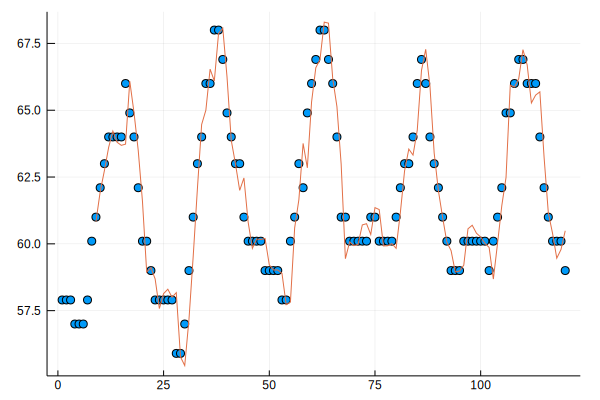

In [36]:
Nplot = 24 * 5
scatter(1:Nplot, t_test[1:Nplot], legend=false)
plot!(M+1:Nplot, ypred[1:Nplot-M])

![図13.8](fig13-8.pdf)

図13.8 2016年5月1日午前12:53から2016年5月5日午後11:53までのロサンゼルス国際空港の1時間毎の気温（点）と，5月1日から5月24日までを訓練データとして用いた自己回帰モデル（係数8個）の予測結果（実線）


## 13.3 特徴量エンジニアリング

本書13.3.5節の家の売却価格回帰のより複雑なモデルを計算する．データを取得するには関数`house_sales_data`を使う．これは長さ774の以下の5つのベクトルからなる辞書である．

- `price`：価格（千ドル単位）
- `area`：面積（1000平方フィート単位）
- `cond`：コンドミニアム（アパート）なら1，そうでなければ0
- `location`：1から4の数字．本書の表13.4中のZIPコードの4つのグループのどれに属するかを表す．

以下のコードはモデルを計算し，実際の価格と予測された価格の散布図をプロットする（図13.9）．なお行列`X`の最後の3列は真偽値（`true`か`false`）である．ここではJuliaが真偽値を1と0の整数として扱うことを利用している．

In [37]:
D = house_sales_data();
price = D["price"];
area = D["area"];
beds = D["beds"];
condo = D["condo"];
location = D["location"];
N = length(price);
X = hcat(ones(N), area, max.(area.-1.5, 0), beds, condo,
           location .== 2, location .== 3,  location .== 4 );
theta = X \ price

8-element Array{Float64,1}:
  115.61682367025571 
  175.4131406399585  
  -42.74776796782588 
  -17.87835523524344 
  -19.04472565054657 
 -100.91050308608219 
 -108.79112222093232 
  -24.765247347062342

In [38]:
rms(X*theta - price)  # RMS予測誤差

68.34428699036884

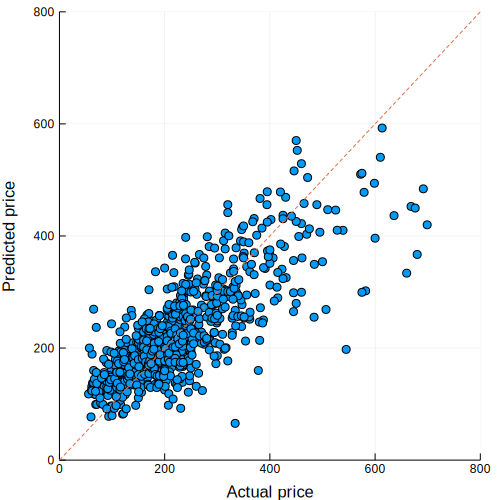

In [39]:
scatter(price, X*theta, lims = (0,800))
plot!([0, 800], [0, 800], linestyle = :dash, legend = false)
plot!(xlims = (0,800), ylims = (0,800), size = (500,500))
plot!(xlabel = "Actual price", ylabel = "Predicted price")

![図13.9](fig13-9.pdf)

図13.9 8パラメータのモデルでフィッティングした結果（点線）と実際のデータ（点）の散布図


最後はこのモデルに対して交差検証を適用する．ここでは＊＊＊ページで簡単な回帰モデルに対して取ったものと同じ（ランダムに5分割するという）アプローチを取る．以下のコードは8個の係数と，訓練集合とテスト集合の各分割のRMS誤差を表示する．

In [40]:
nfold = div(N,5);
import Random;
I = Random.randperm(N);
models = zeros(8,5);  # 5つのフォールドの8つの係数
errors = zeros(2,5);  # 予測誤差

for k = 1:5
    if k == 1
        Itrain = I[nfold+1:end];
        Itest = I[1:nfold];
    elseif k == 5
        Itrain = I[1:4*nfold];
        Itest = I[4*nfold+1:end];
    else
        Itrain = I[ [1:(k-1)*nfold ; k*nfold+1 : N]]
        Itest = I[ [(k-1)*nfold+1 ; k*nfold ]];
    end;
    Ntrain = length(Itrain)
    Ntest = length(Itest)
    theta = X[Itrain,:] \ price[Itrain];
    errors[1,k] = rms(X[Itrain,:] * theta - price[Itrain]);
    errors[2,k] = rms(X[Itest,:] * theta - price[Itest]);
    models[:,k] = theta;
end;

In [41]:
# 5つのフォールドの8つの係数を表示
models

8×5 Array{Float64,2}:
   99.4302   170.873   111.562     94.8932   114.992 
  176.797    165.838   169.287    182.338    181.669 
  -47.9248   -35.6686  -38.5704   -44.2644   -45.4037
  -14.904    -19.2001  -16.7194   -17.6292   -20.7468
  -13.5358   -25.7829  -20.7541   -11.6949   -23.4194
  -93.5074  -138.485   -94.5976   -91.4255   -99.2546
 -104.897   -145.887   -98.4604  -101.648   -105.915 
  -14.5992   -58.9114  -20.0368   -18.6119   -25.5561

In [42]:
# 訓練誤差（1行目）とテスト誤差（2行目）を表示
errors

2×5 Array{Float64,2}:
 68.6268  68.0799  67.3136  67.4183  69.568 
 67.5721  22.3058  68.1762  76.0505  63.5706